In [1]:
#make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f34e0246dd0>


In [2]:
base_input = '../../input_files/trimer_one_species.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
['max_subunits', 3]
['max_interactions', 2]
Using multiGraph
['A']
100.0
Parsing rule...
SPLIT_01:  ['A(a)+A(a)', 'A(a!1).A(a!1)']
['A', 'A', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f34085edd50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f34085edd50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Adding another subunit
Orig edges:  []
Nextn edges:  []
Item edges:  []
Allowed edges: 
('A', 'A')
[True, True]
False
############################3
[]
Connected item Edges:  [('A', 'A')]
New node added--1
['A']
Adding an new edge-- 0 1
Adding an new edge-- 0 1
New node added--2
[0, 1]
Trying internal bonds
Allowed edges: 
('A', 'A')
[True, True]
False
############################3
[(1, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f34dc9

In [9]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    print(n,"--",rn.network.nodes[n]['struct'].edges())
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
0 -- []
1 -- A
1 -- [('A', 'A')]
2 -- A
2 -- [('A', 'A'), ('A', 'A'), ('A', 'A')]
{(0, 1): 0, (0, 2): 1, (1, 2): 1}


In [5]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [ 8995.6678,  8995.6678,  8995.6678, 10987.5746, 10987.5746, 10987.5746] #Max yield Simruntime = 10sec
# new_kon = [ 6476.1292,  6476.1292,  6476.1292, 14140.0743, 14140.0743, 14140.0743]
#new_kon =[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]*np.array([1e4])#Poor yield Simruntime = 1sec

new_kon = new_kon + Tensor([1.]*np.array(1e0))
update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 1}


In [6]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime = 1000
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate()

A
Reactant Sets:
A
Reactant Sets:
(0,)
A
Reactant Sets:
(0, 1)
Before:  tensor([[-2., -1.,  2.,  1.],
        [ 1., -1., -1.,  1.],
        [ 0.,  1., -0., -1.]], dtype=torch.float64)
Shifting to device:  cpu
Using CPU
Start of simulation: memory Used:  80.4
Next time:  tensor(4990.2863, dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
print("Done")

<IPython.core.display.Javascript object>


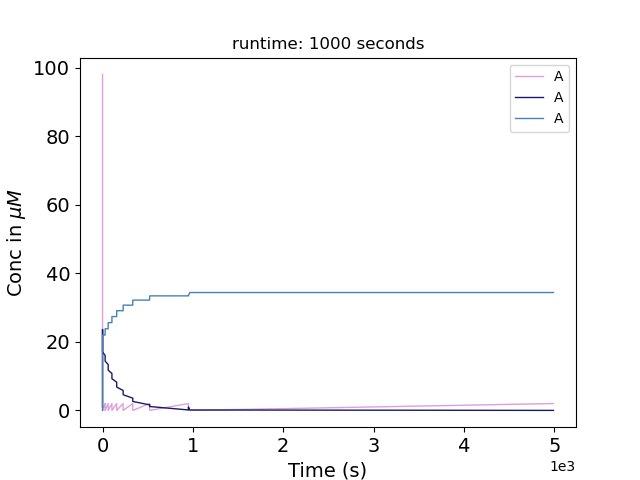

Text(0.5, 1.0, 'runtime: 1000 seconds')

In [8]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()
nodes_list = ['A','B','C','AB','BC','AC','ABC']
sim.plot_observable(nodes_list, ax=ax)
ax.set_title("runtime: " + str(runtime) + " seconds")

In [ ]:
print(vec_rn.copies_vec)
print(vec_rn.kon)
print(sim.steps)

In [ ]:
fig,ax = plt.subplots()
steps = np.array(sim.steps)
bl = (steps>0000000) & (steps<80000000)
#abc = sim.observables[5][1].detach().tonumpy()
print(steps[bl])
ax.scatter(steps[bl],np.array(sim.observables[6][1])[bl])
ax.scatter(steps[bl],np.array(sim.observables[5][1])[bl])
ax.scatter(steps[bl],np.array(sim.observables[0][1])[bl])
print(type(sim.steps))

In [ ]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

In [ ]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)